# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as sp
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller, kpss

from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from scipy import signal

# * * * * * * * * * * * * * * * * * *
#   CLIMBING STATISTICS
# * * * * * * * * * * * * * * * * * *

# Load Data

In [2]:
climb_data = pd.read_csv("climbing_statistics.csv")
climb_data.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,11/27/2015,Disappointment Cleaver,2,0,0.0
1,11/21/2015,Disappointment Cleaver,3,0,0.0
2,10/15/2015,Disappointment Cleaver,2,0,0.0
3,10/13/2015,Little Tahoma,8,0,0.0
4,10/9/2015,Disappointment Cleaver,2,0,0.0


# Data Exploration Climbing Statistics

In [3]:
climb_data.dtypes

Date                   object
Route                  object
Attempted               int64
Succeeded               int64
Success Percentage    float64
dtype: object

In [4]:
climb_data.isnull().values.any()

False

In [5]:
climb_data.shape

(4077, 5)

The date is listed as an object datatype, but it will need to be converted to a datetime type for analysis.

In [6]:
climb_data['Date'] = pd.to_datetime(climb_data['Date'])
climb_data.dtypes

Date                  datetime64[ns]
Route                         object
Attempted                      int64
Succeeded                      int64
Success Percentage           float64
dtype: object

In [7]:
climb_data['Date'].min(), climb_data['Date'].max()
#Start and end of date range

(Timestamp('2014-01-04 00:00:00'), Timestamp('2015-11-27 00:00:00'))

In [8]:
(climb_data['Date'].max() - climb_data['Date'].min()).days +1
# Number of days in data range

693

In [9]:
climb_data['Date'].nunique()

391

In [10]:
climb_data['Route'].nunique()

26

In [11]:
sorted(climb_data['Route'].unique())

['Curtis RIngraham Directge',
 'Disappointment Cleaver',
 'Edmonds HW',
 'Emmons-Winthrop',
 "Fuhrer's Finger",
 'Fuhrers Finger',
 'Gibralter Chute',
 'Gibralter Ledges',
 'Ingraham Direct',
 'Kautz Cleaver',
 'Kautz Glacier',
 'Kautz Headwall',
 'Liberty RIngraham Directge',
 'Liberty Wall',
 'Little Tahoma',
 'Mowich Face',
 'Nisqually Glacier',
 'Ptarmigan RIngraham Directge',
 'Success Cleaver',
 'Sunset Amphitheater',
 'Sunset RIngraham Directge',
 'Tahoma Cleaver',
 'Tahoma Glacier',
 'Unknown',
 'Wilson Headwall',
 'glacier only - no summit attempt']

'Fuhrer's Finger' and 'Fuhrers Finger' refer to the same route, 'Fuhrer Finger'. Other duplicate sounding names refer to different routes.

Note: 'Unknown' and 'glacier only - no summit attempt'. These may skew data.

In [12]:
climb_data.loc[(climb_data.Route == 'Fuhrers Finger'), 'Route'] = 'Fuhrer Finger'
climb_data.loc[(climb_data.Route == "Fuhrer's Finger"), 'Route'] = 'Fuhrer Finger'

In [13]:
climb_data.Route.value_counts()
# Disappointment Cleaver by far the most popular going by number of parties.

Disappointment Cleaver              2728
Emmons-Winthrop                      632
Kautz Glacier                        182
Fuhrer Finger                         92
Gibralter Ledges                      76
Little Tahoma                         70
Liberty RIngraham Directge            69
glacier only - no summit attempt      66
Ingraham Direct                       53
Unknown                               32
Ptarmigan RIngraham Directge          22
Kautz Cleaver                         14
Tahoma Glacier                        11
Success Cleaver                        6
Gibralter Chute                        5
Mowich Face                            4
Sunset RIngraham Directge              3
Nisqually Glacier                      2
Wilson Headwall                        2
Edmonds HW                             2
Curtis RIngraham Directge              2
Kautz Headwall                         1
Sunset Amphitheater                    1
Liberty Wall                           1
Tahoma Cleaver  

Text(0.5, 1.0, 'Number of Parties per Route')

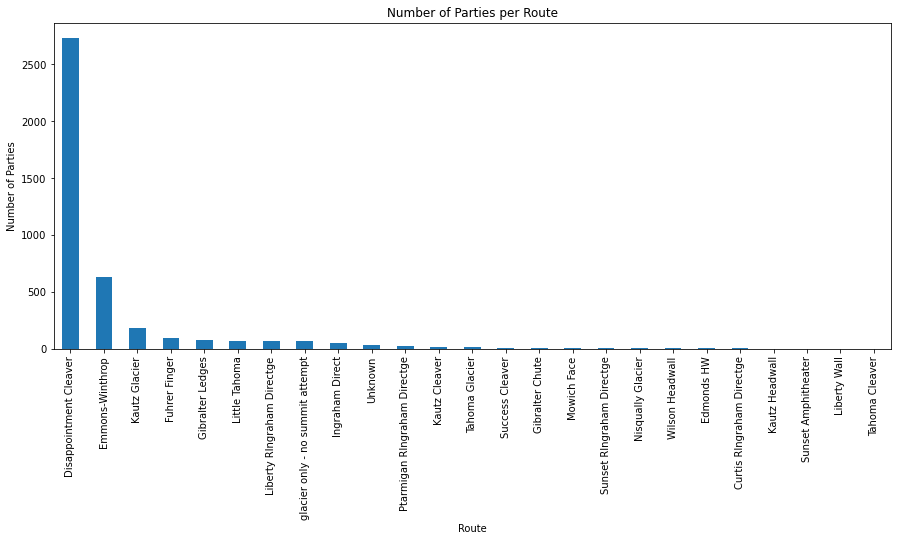

In [14]:
climb_data.Route.value_counts().plot(kind='bar', figsize=(15,6))
plt.ylabel('Number of Parties')
plt.xlabel('Route')
plt.title('Number of Parties per Route')

In [15]:
climb_data.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,2015-11-27,Disappointment Cleaver,2,0,0.0
1,2015-11-21,Disappointment Cleaver,3,0,0.0
2,2015-10-15,Disappointment Cleaver,2,0,0.0
3,2015-10-13,Little Tahoma,8,0,0.0
4,2015-10-09,Disappointment Cleaver,2,0,0.0


In [16]:
climb_data.rename(columns={'Attempted': 'Failed'}, inplace=True)
climb_data.head()

,Date,Route,Failed,Succeeded,Success Percentage
0,2015-11-27,Disappointment Cleaver,2,0,0.0
1,2015-11-21,Disappointment Cleaver,3,0,0.0
2,2015-10-15,Disappointment Cleaver,2,0,0.0
3,2015-10-13,Little Tahoma,8,0,0.0
4,2015-10-09,Disappointment Cleaver,2,0,0.0


In [17]:
climb_data['Failed'].min(), climb_data['Failed'].max()
#Range of Failed

(1, 26)

In [18]:
climb_data['Succeeded'].min(), climb_data['Succeeded'].max()
#Range of Succeeded

(0, 71)

In [19]:
climb_data['Attempted'] = climb_data['Failed'] + climb_data['Succeeded']

In [20]:
climb_data['Attempted'].min(), climb_data['Attempted'].max()
#Range of Attempted

(1, 76)

#### Check what the values in Success Percentage represent

In [21]:
climb_data['Temp'] = climb_data['Succeeded']/climb_data['Failed'] - climb_data['Success Percentage']

In [22]:
climb_data['Temp'].min(), climb_data['Temp'].max()
#Range of Temp

(-4.5454545682943603e-10, 4.545454013182848e-10)

In [23]:
climb_data = climb_data.drop('Temp', 1)
climb_data = climb_data.drop('Success Percentage', 1)


#### Calculate Success Rate

In [24]:
# The column 'SuccessRate' has been calculated wrongly, since if gives the ratio between succeeded and failed attempts, not the percentage of succeeded attempts.
climb_data['SuccessRate'] = climb_data['Succeeded']/climb_data['Attempted']

In [25]:
climb_data['SuccessRate'].min(), climb_data['SuccessRate'].max()
#Range of SuccessRate

(0.0, 0.9342105263157895)

In [26]:
climb_data.head()

,Date,Route,Failed,Succeeded,Attempted,SuccessRate
0,2015-11-27,Disappointment Cleaver,2,0,2,0.0
1,2015-11-21,Disappointment Cleaver,3,0,3,0.0
2,2015-10-15,Disappointment Cleaver,2,0,2,0.0
3,2015-10-13,Little Tahoma,8,0,8,0.0
4,2015-10-09,Disappointment Cleaver,2,0,2,0.0


## Compare Routes

In [27]:
climb_data.groupby(['Route']).sum()[['Failed', 'Succeeded', 'Attempted']].sort_values('Attempted', ascending = False).head(10)

,Failed,Succeeded,Attempted
Route,,,
Disappointment Cleaver,15259,8353,23612
Emmons-Winthrop,3048,1673,4721
Kautz Glacier,949,530,1479
Little Tahoma,296,135,431
Fuhrer Finger,273,88,361
Gibralter Ledges,199,58,257
Liberty RIngraham Directge,165,82,247
Ingraham Direct,225,16,241
glacier only - no summit attempt,187,15,202


Text(0.5, 1.0, 'Number of Attempted, Failed and Succeded per Route')

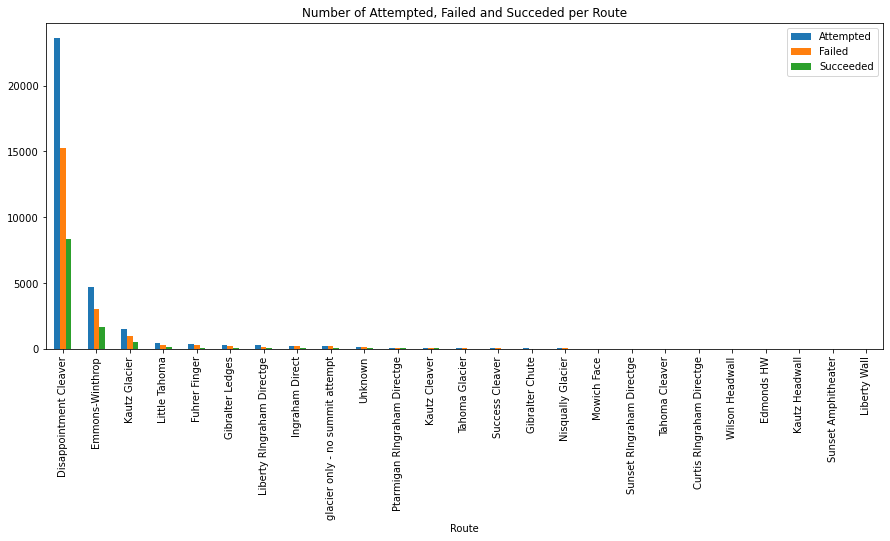

In [28]:
climb_data.groupby(['Route']).sum()[['Attempted', 'Failed', 'Succeeded']].sort_values('Attempted', ascending = False).plot.bar(figsize=(15,6))
plt.xlabel('Route')
plt.title('Number of Attempted, Failed and Succeded per Route')

#Disappointment Cleaver by far the most popular route going by individual attempts, successes or failures.
#Unknown attempts neglibible considering the total number of attempts, successes or failures

<AxesSubplot:xlabel='Route'>

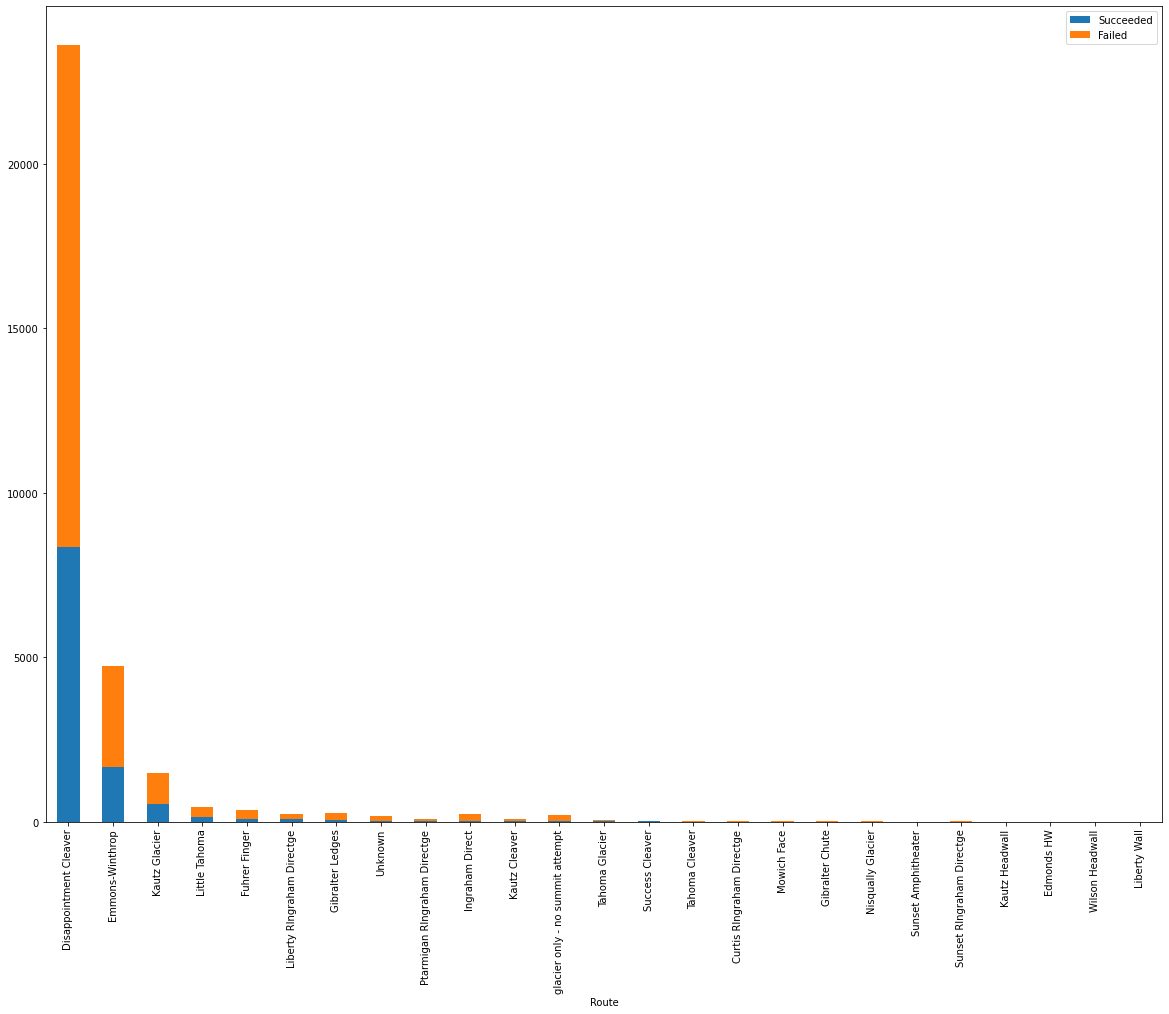

In [29]:
climb_data.groupby(['Route']).sum()[['Succeeded', 'Failed']].sort_values('Succeeded', ascending = False).plot.bar(stacked=True, figsize=(20,15))


<AxesSubplot:xlabel='Route'>

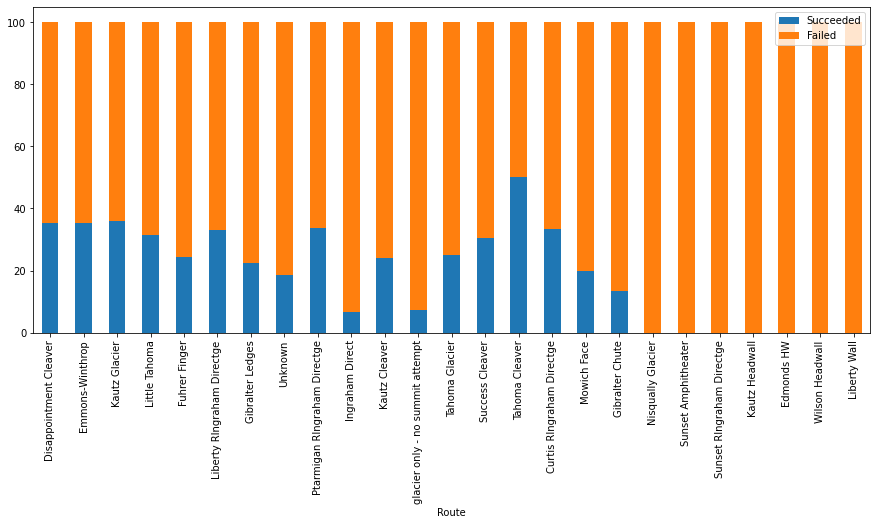

In [30]:
climb_data.groupby(['Route']).sum()[['Succeeded', 'Failed']].sort_values('Succeeded', ascending = False).apply(lambda r: r/r.sum()*100, axis=1).plot.bar(stacked=True, figsize=(15,6))

In [31]:
climb_data[climb_data['Route']== 'Tahoma Cleaver']

,Date,Route,Failed,Succeeded,Attempted,SuccessRate
1513,2015-06-05,Tahoma Cleaver,3,3,6,0.5


#### Disappointment Cleaver has the highest number of successes. Tahoma Cleaver has the highest success rate, but since there are only 3 successes and 6 attempts, this is not statistically significant. Disappointment Cleaver, Emmons-Winthrop and Kautz Glacier have the next highest three success rates and they are very close to each other. They are also the routes with the highest number of succeeded attempts.

## Data exploration of 'Disappointment' subset

In [32]:
disappointment = climb_data[climb_data['Route']== 'Disappointment Cleaver']
disappointment.shape

(2728, 6)

In [33]:
disappointment['Date'].min(), disappointment['Date'].max()
#Start and end of date range

(Timestamp('2014-01-05 00:00:00'), Timestamp('2015-11-27 00:00:00'))

In [34]:
(disappointment['Date'].max() - disappointment['Date'].min()).days +1
# Number of days in data range

692

In [35]:
disappointment['Date'].nunique()

330

<AxesSubplot:xlabel='Date'>

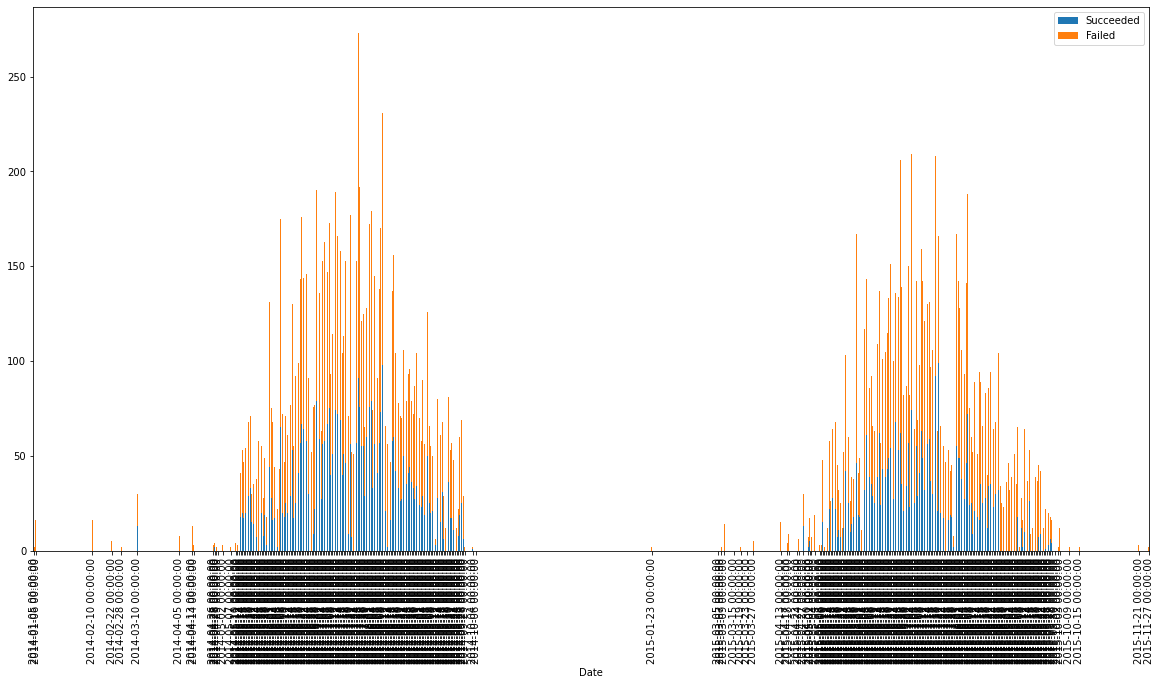

In [36]:
disappointment.groupby(['Date']).sum()[['Succeeded', 'Failed']].plot.bar(stacked=True, figsize=(20,10))


Text(0.5, 1.0, 'Success and Failure Rate over Time')

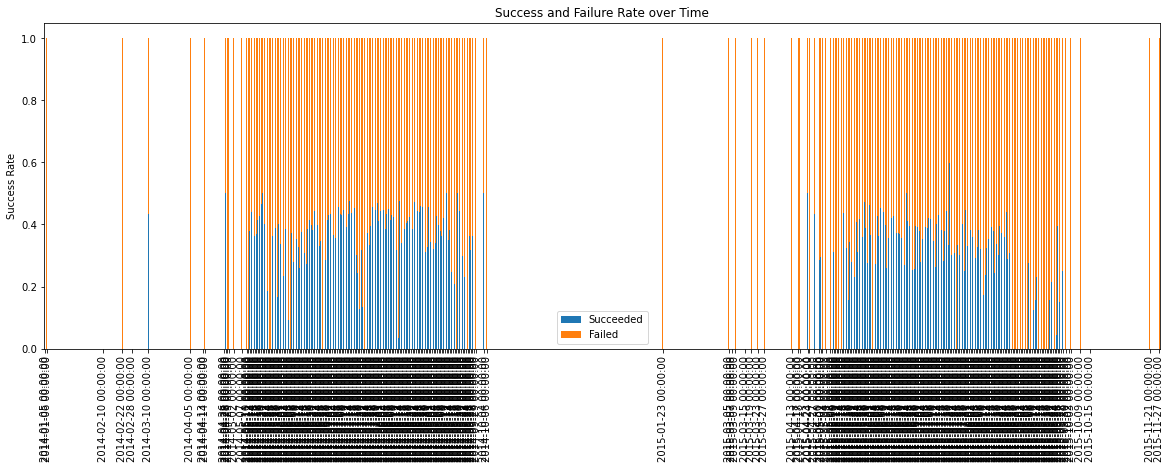

In [37]:
disappointment.groupby(['Date']).sum()[['Succeeded', 'Failed']].apply(lambda r: r/r.sum(), axis=1).plot.bar(stacked=True, figsize=(20,6))
plt.xlabel('')
plt.ylabel('Success Rate')
plt.title('Success and Failure Rate over Time')

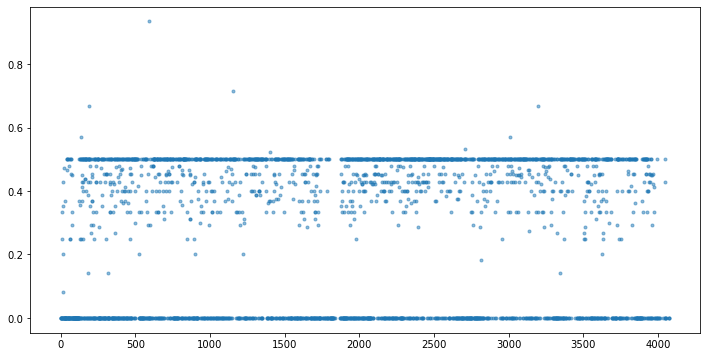

In [38]:
plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(disappointment['SuccessRate'], marker = '.', alpha = 0.5, linestyle = 'none')

## Aggregate disappointment data by date

In [39]:
disappointment_agg = disappointment.groupby('Date', as_index=False).sum()
disappointment_agg['SuccessRate'] = disappointment_agg['Succeeded'] / disappointment_agg['Attempted']

disappointment_agg.head()

,Date,Failed,Succeeded,Attempted,SuccessRate
0,2014-01-05,2,0,2,0.0
1,2014-01-06,16,0,16,0.0
2,2014-02-10,16,0,16,0.0
3,2014-02-22,5,0,5,0.0
4,2014-02-28,2,0,2,0.0


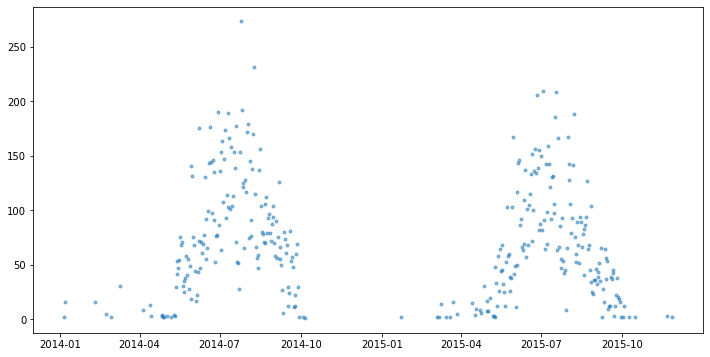

In [40]:
plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(disappointment_agg['Date'], disappointment_agg['Attempted'], marker = '.', alpha = 0.5, linestyle = 'none')

Text(0.5, 1.0, 'Succes rate over Time for Disappointment Cleaver ')

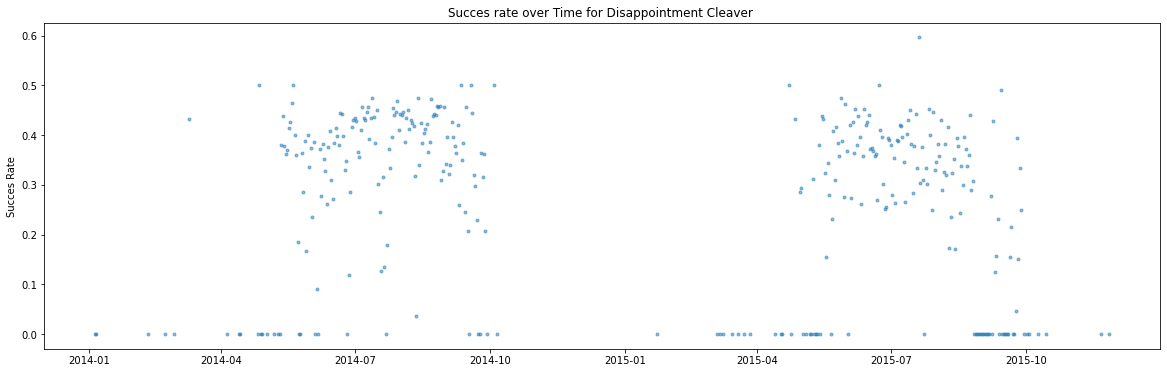

In [41]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.plot(disappointment_agg['Date'], disappointment_agg['SuccessRate'], marker = '.', alpha = 0.5, linestyle = 'none')
plt.ylabel('Succes Rate')
plt.title('Succes rate over Time for Disappointment Cleaver ')

# Linear Regression

Over full two years of data set

In [42]:
y=np.array(disappointment['SuccessRate'].values, dtype=float)
x=np.array(disappointment.Date.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

r =  -0.10497458074055462 
 p =  3.895478144158654e-08 
 s =  2.794032802070838e-19


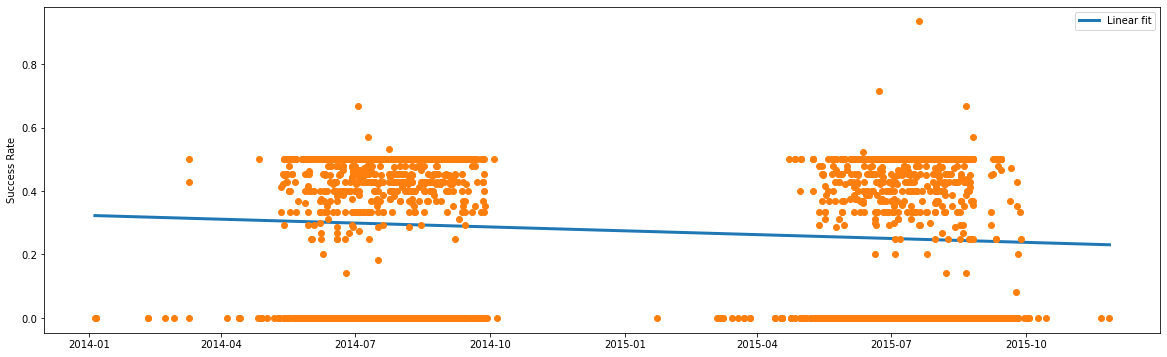

In [43]:
f, ax = plt.subplots(1, 1)
ax.plot(xf1, yf,label='Linear fit', lw=3)
plt.plot(disappointment['Date'], disappointment['SuccessRate'], marker='o', ls='')
plt.ylabel('Success Rate')
ax.legend();

In [44]:
y=np.array(disappointment_agg['SuccessRate'].values, dtype=float)
x=np.array(disappointment_agg.Date.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),100)
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

r =  -0.15221083503883717 
 p =  0.005593298768120038 
 s =  5.6648692374905515e-19


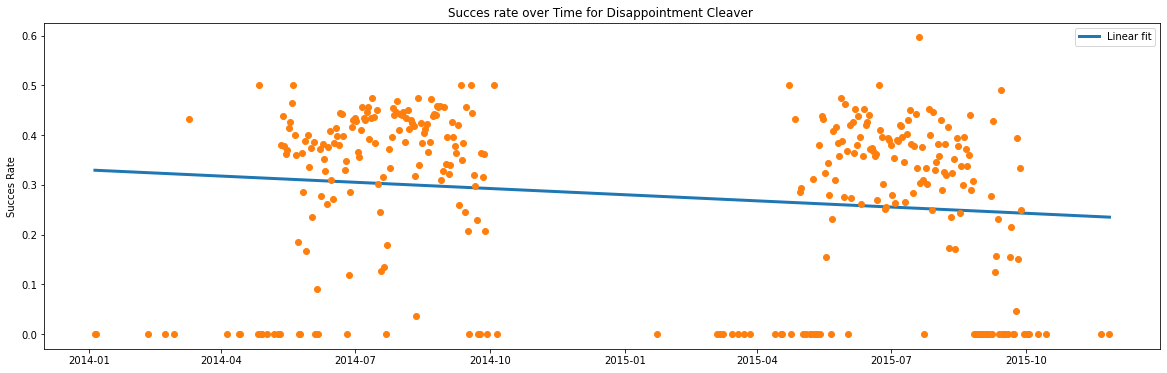

In [45]:
f, ax = plt.subplots(1, 1,figsize=(20,6))
ax.plot(xf1, yf,label='Linear fit', lw=3)
plt.plot(disappointment_agg['Date'], disappointment_agg['SuccessRate'], marker='o', ls='')
plt.ylabel('Succes Rate')
plt.title('Succes rate over Time for Disappointment Cleaver ')
ax.legend();

## Seasonal plot of Time Series

In [46]:
# Prepare data
disappointment_agg['year'] = [d.year for d in disappointment_agg.Date]

disappointment_agg['year_month'] = [str(d.year)+'-'+d.strftime('%m') for d in disappointment_agg.Date]

disappointment_agg['month'] = [d.strftime('%m') for d in disappointment_agg.Date]
years = disappointment_agg['year'].unique()
disappointment_agg['month'] = pd.to_numeric(disappointment_agg['month'])

In [47]:
disappointment_agg.head()

,Date,Failed,Succeeded,Attempted,SuccessRate,year,year_month,month
0,2014-01-05,2,0,2,0.0,2014,2014-01,1
1,2014-01-06,16,0,16,0.0,2014,2014-01,1
2,2014-02-10,16,0,16,0.0,2014,2014-02,2
3,2014-02-22,5,0,5,0.0,2014,2014-02,2
4,2014-02-28,2,0,2,0.0,2014,2014-02,2


Text(0, 0.5, 'Success Rate')

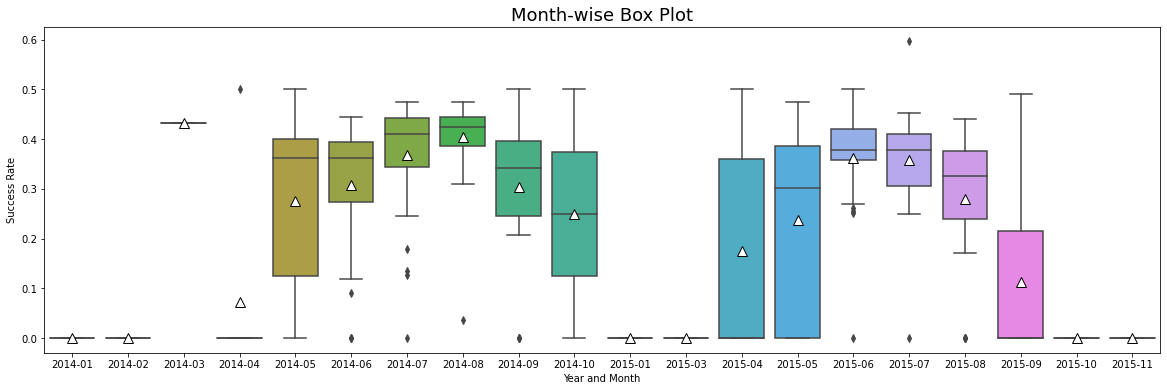

In [48]:
plt.figure(figsize=(20,6))
sns.boxplot(x='year_month', y='SuccessRate', data=disappointment_agg.loc[~disappointment_agg.year.isin([2013, 2016]), :], showmeans=True, meanprops={"markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})
plt.title('Month-wise Box Plot', fontsize=18)
plt.xlabel('Year and Month')
plt.ylabel('Success Rate')

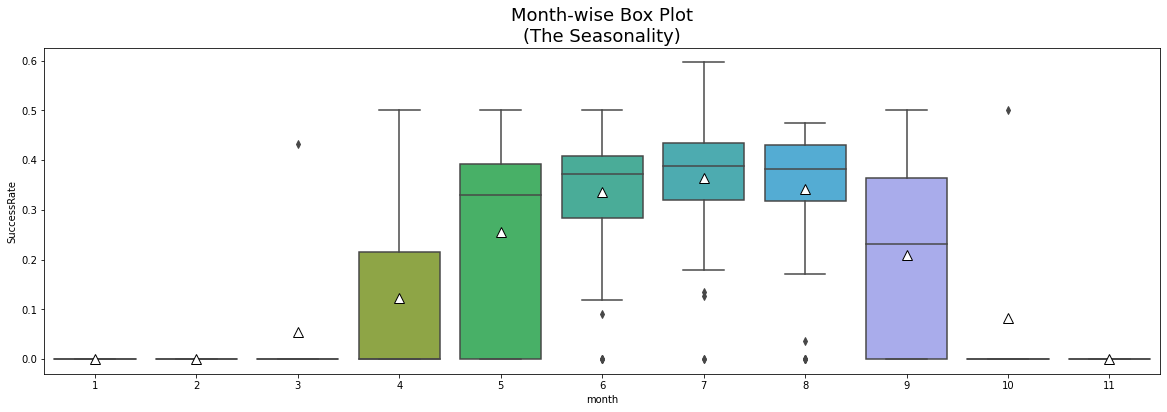

In [49]:
# Draw Plot
plt.figure(figsize=(20,6))
sns.boxplot(x='month', y='SuccessRate', data=disappointment_agg.loc[~disappointment_agg.year.isin([2013, 2016]), :], showmeans=True, meanprops={"markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})

# Set Title
plt.title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Text(0, 0.5, 'Success Rate')

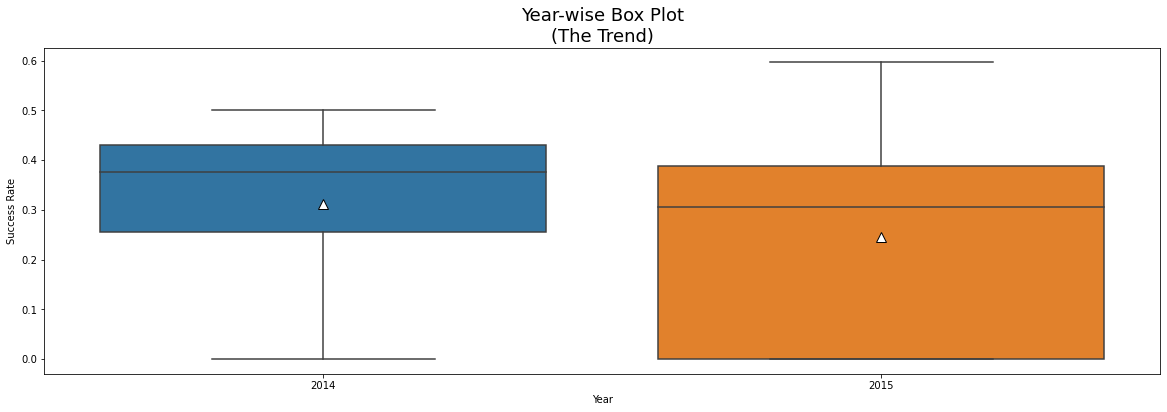

In [50]:
plt.figure(figsize=(20,6))
sns.boxplot(x='year', y='SuccessRate', data=disappointment_agg, showmeans=True, meanprops={"markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"})
plt.title('Year-wise Box Plot\n(The Trend)', fontsize=18)
plt.xlabel('Year')
plt.ylabel('Success Rate')


Text(0.5, 1.0, 'Number of Attempts per Month over Both Years')

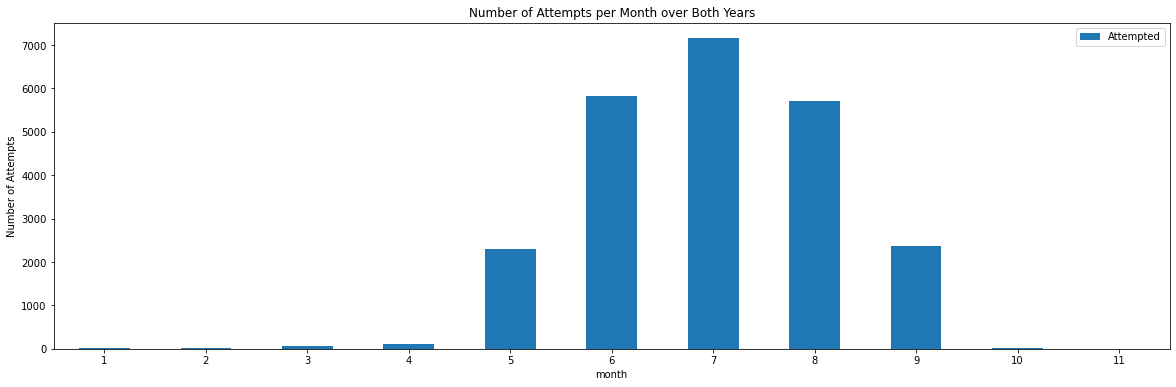

In [51]:
disappointment_agg.groupby(['month']).sum()[['Attempted']].plot.bar(figsize=(20,6), rot=0)
plt.ylabel('Number of Attempts')
plt.title('Number of Attempts per Month over Both Years')

In [52]:
disappointment_agg.groupby(['month']).sum()[['Attempted']]

,Attempted
month,
1,20
2,23
3,73
4,114
5,2302
6,5830
7,7159
8,5701
9,2364


In [53]:
disappointment_agg.dtypes

Date           datetime64[ns]
Failed                  int64
Succeeded               int64
Attempted               int64
SuccessRate           float64
year                    int64
year_month             object
month                   int64
dtype: object

In [54]:
# ADF Test
result = adfuller(disappointment_agg.SuccessRate.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -5.196724006064108
p-value: 8.928496110239404e-06
Critial Values:
   1%, -3.45050711373316
Critial Values:
   5%, -2.8704195794076743
Critial Values:
   10%, -2.571500856923753


In [55]:

# KPSS Test
result = kpss(disappointment_agg.SuccessRate.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.229586
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\Users\Owner\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [56]:
disappointment_agg_month = disappointment_agg.groupby(['month']).mean()[['SuccessRate']].reset_index()
disappointment_agg_month

,month,SuccessRate
0,1,0.000000
1,2,0.000000
2,3,0.054167
3,4,0.122789
4,5,0.255468
5,6,0.334939
6,7,0.363149
7,8,0.341575
8,9,0.208332
9,10,0.083333


In [57]:
x1 = disappointment_agg_month['month']
x1

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
Name: month, dtype: int64

In [58]:
y1 = disappointment_agg_month['SuccessRate']
y1

0     0.000000
1     0.000000
2     0.054167
3     0.122789
4     0.255468
5     0.334939
6     0.363149
7     0.341575
8     0.208332
9     0.083333
10    0.000000
Name: SuccessRate, dtype: float64

In [59]:
fit1 = np.polyfit(x1, y1, 1)  # linear
fit2 = np.polyfit(x1, y1, 2)  # quadratic
fit3 = np.polyfit(x1, y1, 3)  # cubic

In [60]:
v1 = np.polyval(fit1, x1)
np.mean(np.square(y1 - v1)) 

0.017745900678414157

In [61]:
v2 = np.polyval(fit2, x1)
np.mean(np.square(y1 - v2))

0.00381702029203396

In [62]:
v3 = np.polyval(fit3, x1)
np.mean(np.square(y1 - v3))

0.001511208731525198

In [ ]:
plt.scatter(x1, y1, color='red')
plt.scatter(x1, v1, color='yellow')
plt.scatter(x1, v2, color='green')
plt.scatter(x1, v3, color='blue')
plt.plot(x1, y1, color='red')
plt.plot(x1, v1, color='yellow')
plt.plot(x1, v2, color='green')
plt.plot(x1, v3, color='blue')
red_patch = mpatches.Patch(color='red', label='Original')
yellow_patch = mpatches.Patch(color='yellow', label='Linear')
green_patch = mpatches.Patch(color='green', label='Quadratic')
blue_patch = mpatches.Patch(color='blue', label='Cubic')
plt.legend(handles=[red_patch, yellow_patch, green_patch, blue_patch])
plt.title('Seasonal Regression Analysis', fontsize=18)
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.show()

In [ ]:
p1 = np.polyval(fit3, 1)
p1

In [ ]:
p2 = np.polyval(fit3, 2)
p2

In [ ]:
p12 = np.polyval(fit3, 12)
p12

# * * * * * * * * * * * * * * * * * * *
#   WEATHER STATISTICS
# * * * * * * * * * * * * * * * * * * *

# Load Data

In [ ]:
weather_data = pd.read_csv("Rainier_Weather.csv")
weather_data.head()

# Data Exploration and Preparation

In [ ]:
weather_data.dtypes

In [ ]:
weather_data.isnull().values.any()

In [ ]:
weather_data.shape

In [ ]:
weather_data['Date'] = pd.to_datetime(weather_data['Date'])
weather_data.dtypes

In [ ]:
weather_data = weather_data.drop('Battery Voltage AVG', 1)

In [ ]:
weather_data['Date'].min(), weather_data['Date'].max()
#Start and end of date range

In [ ]:
(weather_data['Date'].max() - weather_data['Date'].min()).days +1
# Number of days in data range

In [ ]:
weather_data['Date'].nunique()

In [ ]:
weather_data['Temperature AVG'].min(), weather_data['Temperature AVG'].max()
#Start and end of Temperature AVG range

In [ ]:
plt.plot(weather_data['Date'], weather_data['Temperature AVG'])
plt.xlabel('')
plt.ylabel('Temperature')
plt.title('Temperature over Time', fontsize=18)

In [ ]:
plt.hist(weather_data['Temperature AVG'], bins = 30)
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Temperature Frequency', fontsize=18)

In [ ]:
weather_data['Relative Humidity AVG'].min(), weather_data['Relative Humidity AVG'].max()
#Start and end of Relative Humidity AVG range

In [ ]:
plt.plot(weather_data['Date'], weather_data['Relative Humidity AVG'])
plt.xlabel('')
plt.ylabel('Relative Humidity')
plt.title('Relative Humidity over Time', fontsize=18)

In [ ]:
plt.hist(weather_data['Relative Humidity AVG'], bins = 30)
plt.xlabel('Relative Humidity')
plt.ylabel('Count')
plt.title('Relative Humidity Frequency', fontsize=18)

In [ ]:
weather_data['Wind Speed Daily AVG'].min(), weather_data['Wind Speed Daily AVG'].max()
#Start and end of Wind Speed Daily AVG range

In [ ]:
plt.plot(weather_data['Date'], weather_data['Wind Speed Daily AVG'])
plt.xlabel('')
plt.ylabel('Wind Speed Daily')
plt.title('Wind Speed Daily over Time', fontsize=18)

In [ ]:
plt.hist(weather_data['Wind Speed Daily AVG'], bins = 30)
plt.xlabel('Wind Speed Daily')
plt.ylabel('Count')
plt.title('Wind Speed Daily Frequency', fontsize=18)

In [ ]:
weather_data['Wind Direction AVG'].min(), weather_data['Wind Direction AVG'].max()
#Start and end of Wind Direction AVG range

In [ ]:
plt.plot(weather_data['Date'], weather_data['Wind Direction AVG'])
plt.xlabel('')
plt.ylabel('Wind Direction')
plt.title('Wind Direction over Time', fontsize=18)

In [ ]:
plt.hist(weather_data['Wind Direction AVG'], bins = 32)
plt.xlabel('Wind Direction')
plt.ylabel('Count')
plt.title('Wind Direction Frequency', fontsize=18)

In [ ]:
weather_data['Solare Radiation AVG'].min(), weather_data['Solare Radiation AVG'].max()
#Start and end of Solare Radiation AVG range

In [ ]:
plt.plot(weather_data['Date'], weather_data['Solare Radiation AVG'])
plt.xlabel('')
plt.ylabel('Solare Radiation')
plt.title('Solare Radiation over Time', fontsize=18)

In [ ]:
plt.hist(weather_data['Solare Radiation AVG'], bins = 30)
plt.xlabel('Solare Radiation')
plt.ylabel('Count')
plt.title('Solare Radiation Frequency', fontsize=18)

# * * * * * * * * * * * * * * *
#   COMBINED DATA
# * * * * * * * * * * * * * * *

In [ ]:
combined_data = pd.merge(disappointment_agg, weather_data, how="inner", on='Date')

In [ ]:
combined_data.head(10)

In [ ]:
combined_data.shape

In [ ]:
combined_data['Date'].min(), combined_data['Date'].max()
#Start and end of date range

In [ ]:
(combined_data['Date'].max() - combined_data['Date'].min()).days +1
# Number of days in date range

In [ ]:
combined_data_slim = combined_data.drop(['Failed', 'Succeeded', 'Attempted', 'year', 'year_month', 'month'], 1)

In [ ]:
combined_data_slim.head()

In [ ]:
corr = combined_data_slim.corr()
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)

In [ ]:
corr

#### Splitting the data

In [ ]:
feature_col_names = ['Temperature AVG', 'Relative Humidity AVG', 'Wind Speed Daily AVG', 'Wind Direction AVG', 'Solare Radiation AVG', 'Date']
predict_col_name = ['SuccessRate']

X = combined_data_slim[feature_col_names].values
y = combined_data_slim[predict_col_name].values
split_test_size = 0.3

X_train_date, X_test_date, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42)

In [ ]:
X_train = np.delete(X_train_date, 5, 1)
X_test = np.delete(X_test_date, 5, 1)

In [ ]:
len(X_train)/len(combined_data_slim.index), len(X_test)/len(combined_data_slim.index)

In [ ]:
np.mean(y_train), np.mean(y_test)

#### Traning and Testing Algorithm

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

In [ ]:
regr.coef_

In [ ]:
predict_train = regr.predict(X_train)
predict_test = regr.predict(X_test)

In [ ]:
regr.score(X_train, y_train)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
alphas = np.logspace(-4, 0, 12)
alphas


In [ ]:
regr = linear_model.Lasso()
scores = [regr.set_params(alpha=alpha)
              .fit(X_train, y_train)
              .score(X_test, y_test)
          for alpha in alphas]
best_alpha = alphas[scores.index(max(scores))]
regr.alpha = best_alpha
regr.fit(X_train, y_train)

In [ ]:
regr.score(X_train, y_train)

In [ ]:
regr.score(X_test, y_test)


In [ ]:
regr.coef_

#### plotting predictions and actuals

In [ ]:
test_results = pd. DataFrame(X_test_date, columns=['Temperature AVG', 'Relative Humidity AVG', 'Wind Speed Daily AVG', 'Wind Direction AVG', 'Solare Radiation AVG', 'Date']) 
test_results.head()

In [ ]:
test_results['SuccessRate'] = y_test

In [ ]:
test_results['SuccessRatePrediction'] = predict_test

In [ ]:
test_results = test_results.set_index('Date').sort_index()

In [ ]:
test_results.head()

In [ ]:
test_resultsA = test_results.loc[:'2015-04-01']
test_resultsB = test_results.loc['2015-04-01':]

In [ ]:
test_resultsA[['SuccessRate', 'SuccessRatePrediction']].sort_values('Date', ascending = False).plot.bar(figsize=(40,6))
plt.xlabel('Date')
plt.title('Actual and Predicted Succes Rate over Time')


In [ ]:
test_resultsB[['SuccessRate', 'SuccessRatePrediction']].sort_values('Date', ascending = False).plot.bar(figsize=(40,6))
plt.xlabel('Date')
plt.title('Actual and Predicted Succes Rate over Time')

#### Predicting with Algorithm

In [ ]:
new = weather_data[(weather_data['Date'] > '2015-11-27')]

In [ ]:
X_new_date = new[feature_col_names].values

In [ ]:
X_new = np.delete(X_new_date, 5, 1)

In [ ]:
predict_new = regr.predict(X_new)

In [ ]:
predict_test.shape

In [ ]:
new.shape

In [ ]:
new['SuccessRatePrediction'] = predict_new

In [ ]:
new.head()

In [ ]:
new = new.set_index('Date')

In [ ]:
new = new[['SuccessRatePrediction']]

In [ ]:
new

In [ ]:
new.plot()
plt.ylabel('Success Rate')
plt.title('Success Rate Prediction 28-NOV-2015 through 31-DEC-2015', fontsize=18)